In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

# Machine learning models and tools
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# This is from a different library
from xgboost import XGBRegressor    

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [102]:
# Create a dataframe of the csv file
data = pd.read_csv("final_dataset.csv")
data.head()

,category,product name,location,price,overall rating,number sold,total review,customer review,sentiment,region,salary
0,computers and laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,jakarta utara,53500,4.9,5449,2369,Alhamdulillah berfungsi dengan baik. Packaging...,1,dki jakarta,5396760.0
1,computers and laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,tangerang selatan,72000,4.9,2359,1044,"barang bagus dan respon cepat, harga bersaing ...",1,banten,2905119.0
2,computers and laptops,SSD Midasforce 128 Gb - Tanpa Caddy,jakarta barat,213000,5.0,12300,3573,"barang bagus, berfungsi dengan baik, seler ram...",1,dki jakarta,5396760.0
3,computers and laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,jakarta timur,55000,4.7,2030,672,bagus sesuai harapan penjual nya juga ramah. t...,1,dki jakarta,5396760.0
4,computers and laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,jakarta timur,55000,4.7,2030,672,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",1,dki jakarta,5396760.0


In [103]:
x = data[["price","overall rating","sentiment","salary"]]
y = data["number sold"]

print("x shape:", x.shape)

x shape: (5147, 4)


In [104]:
# Another data split for the x data with no added polynomial features (this is for the tree based models)
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42
)

In [105]:
LR = LinearRegression()
RFR = RandomForestRegressor()
XGB = XGBRegressor()

TRAINING THE MACHINE LEARNING MODELS

In [106]:
# 1. Linear Regression
LR.fit(x_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [107]:
# 2. Random Forest Regressora
RFR.fit(x_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [108]:
# 3. XGBoost Regressor
XGB.fit(x_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [109]:
# PREDICTIONS
pred_lr  = LR.predict(x_test)
pred_rf  = RFR.predict(x_test)
pred_xgb = XGB.predict(x_test)

# EVALUATION
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Evaluation Metrics for {model_name}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R2 ): {r2}")
    print("\n")

evaluate_model(y_test, pred_lr, "Linear Regression")
evaluate_model(y_test, pred_rf, "Random Forest Regressor")
evaluate_model(y_test, pred_xgb, "XGBoost Regressor")

Evaluation Metrics for Linear Regression:
Mean Absolute Error (MAE): 8265.264986313845
Mean Squared Error (MSE): 269551212.4506081
R-squared (R2 ): 0.028235048230113025


Evaluation Metrics for Random Forest Regressor:
Mean Absolute Error (MAE): 1710.9846224310888
Mean Squared Error (MSE): 30279508.026782546
R-squared (R2 ): 0.8908386855701719


Evaluation Metrics for XGBoost Regressor:
Mean Absolute Error (MAE): 2705.14013671875
Mean Squared Error (MSE): 43397140.0
R-squared (R2 ): 0.843548059463501




C:\Users\Barri\AppData\Local\Temp\ipykernel_16156\1081100208.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


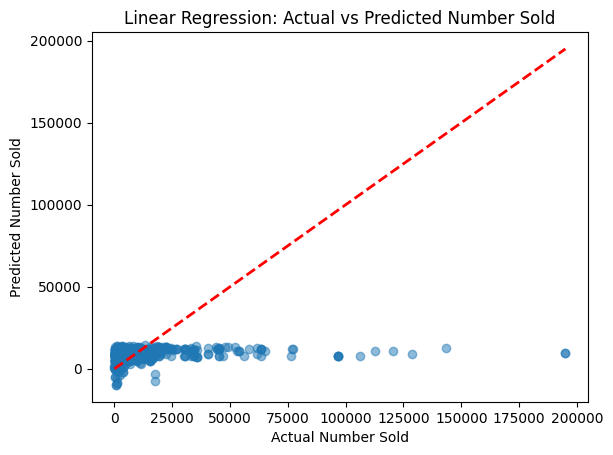

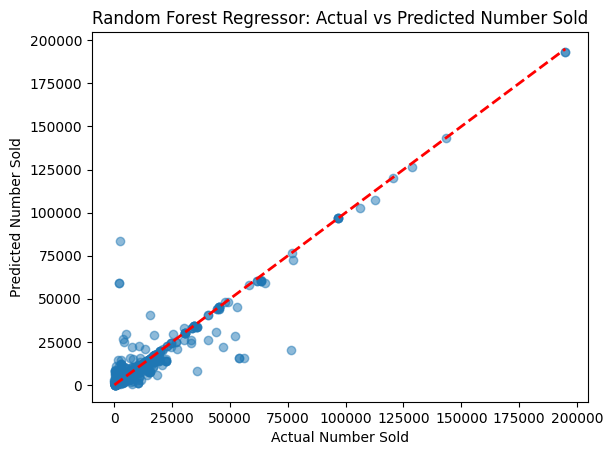

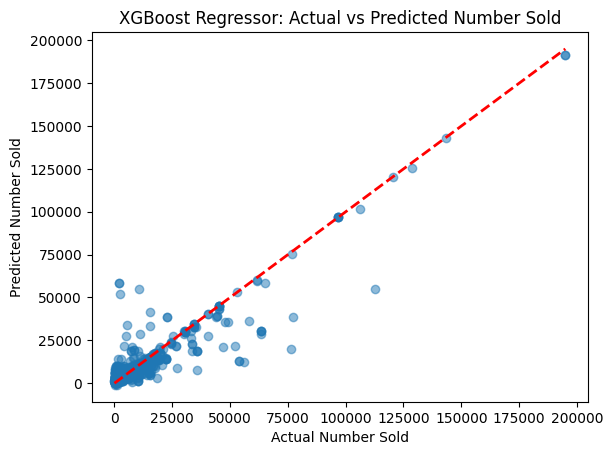

In [110]:
# Actual prediction vs predicted plot for the best model
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Number Sold")
    plt.ylabel("Predicted Number Sold")
    plt.title(f"{model_name}: Actual vs Predicted Number Sold")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
    plt.show()

plot_actual_vs_predicted(y_test, pred_lr, "Linear Regression")
plot_actual_vs_predicted(y_test, pred_rf, "Random Forest Regressor")
plot_actual_vs_predicted(y_test, pred_xgb, "XGBoost Regressor")

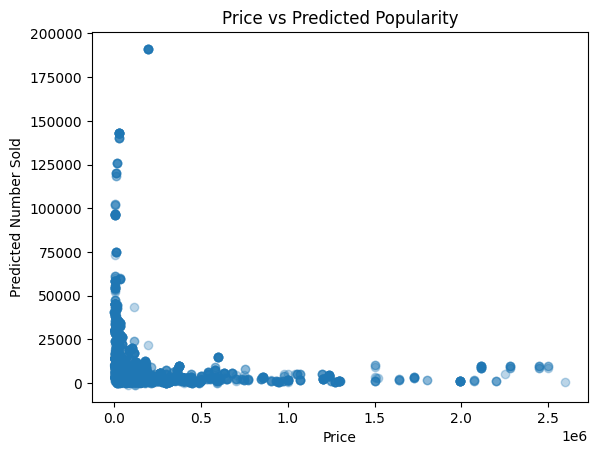

In [111]:
# Finding the optimal price ranges using the dataset, by plotting the prices vs predicted number sold
data["predicted sold"] = XGB.predict(x)
plt.scatter(data["price"], data["predicted sold"], alpha=0.3)
plt.xlabel("Price")
plt.ylabel("Predicted Number Sold")
plt.title("Price vs Predicted Popularity")
plt.show()

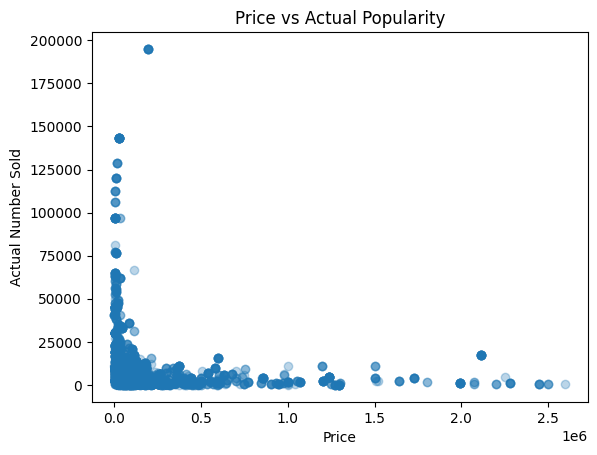

In [112]:
plt.scatter(data["price"], data["number sold"], alpha=0.3)
plt.xlabel("Price")
plt.ylabel("Actual Number Sold")
plt.title("Price vs Actual Popularity")
plt.show()

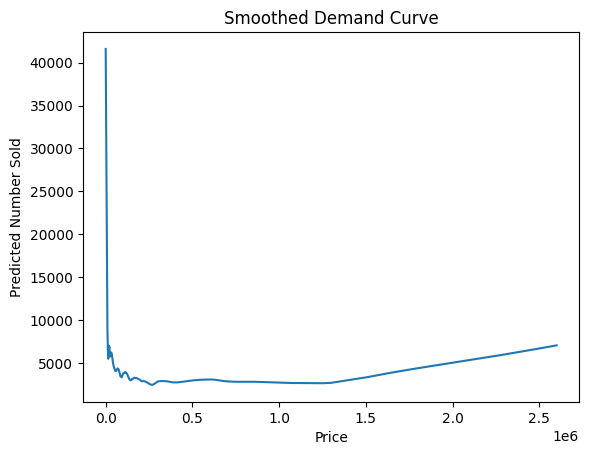

In [113]:
from statsmodels.nonparametric.smoothers_lowess import lowess

data_smooth = data[["price", "predicted sold"]].dropna().sort_values("price")
smooth = lowess(data_smooth["predicted sold"], data_smooth["price"], frac=0.12)

plt.plot(smooth[:,0], smooth[:,1])
plt.xlabel("Price")
plt.ylabel("Predicted Number Sold")
plt.title("Smoothed Demand Curve")
plt.show()


In [114]:
ideal_ranges = {}

for c in data["category"].unique():
    sub = data[data["category"] == c]
    thr = sub["predicted sold"].quantile(0.90)
    top = sub[sub["predicted sold"] >= thr]
    
    ideal_ranges[c] = (top["price"].min(), top["price"].max())

# Display formatted results
for category, (min_price, max_price) in ideal_ranges.items():
    print(f"{category}: {int(min_price)} ~ {int(max_price)}")


computers and laptops: 18000 ~ 370000
toys and hobbies: 4150 ~ 27000
food and drink: 5400 ~ 26000
office & stationery: 1550 ~ 11799
automotive: 1500 ~ 65000
animal care: 3500 ~ 29500
body care: 29100 ~ 29100
party supplies and craft: 349 ~ 110000
carpentry: 3300 ~ 3700
other products: 1400 ~ 2040
sport: 4900 ~ 19500
precious metal: 39100 ~ 39100
property: 8400 ~ 40000
tour and travel: 169000 ~ 749900
books: 4000 ~ 180000
kitchen: 3199 ~ 43000
electronics: 4500 ~ 39000
kids and baby fashion: 9000 ~ 9250
muslim fashion: 3345 ~ 15000
men's fashion: 8900 ~ 1500000
women's fashion: 15000 ~ 30500
movies and music: 10000 ~ 195000
gaming: 850 ~ 125000
phones and tablets: 18000 ~ 175000
mother and baby: 31478 ~ 71390
camera: 8900 ~ 180000
beauty: 7800 ~ 125000
health: 14000 ~ 43000
household: 825 ~ 115000


In [115]:
data

,category,product name,location,price,overall rating,number sold,total review,customer review,sentiment,region,salary,predicted sold
0,computers and laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,jakarta utara,53500,4.9,5449,2369,Alhamdulillah berfungsi dengan baik. Packaging...,1,dki jakarta,5396760.0,5131.833496
1,computers and laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,tangerang selatan,72000,4.9,2359,1044,"barang bagus dan respon cepat, harga bersaing ...",1,banten,2905119.0,2911.230713
2,computers and laptops,SSD Midasforce 128 Gb - Tanpa Caddy,jakarta barat,213000,5.0,12300,3573,"barang bagus, berfungsi dengan baik, seler ram...",1,dki jakarta,5396760.0,3660.076172
3,computers and laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,jakarta timur,55000,4.7,2030,672,bagus sesuai harapan penjual nya juga ramah. t...,1,dki jakarta,5396760.0,2898.204102
4,computers and laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,jakarta timur,55000,4.7,2030,672,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",1,dki jakarta,5396760.0,2898.204102
...,...,...,...,...,...,...,...,...,...,...,...,...
5142,household,PCK-01 Penjepit Barang / Pickup Tool Ver.1 Ala...,jakarta pusat,35000,4.9,1431,562,"Harga bersaing, barang sesuai pesanan. Saya na...",1,dki jakarta,5396760.0,9877.875000
5143,household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,jakarta utara,99000,4.9,15529,4074,Beli ini krn Anak & Istri mau liburan di Jakar...,1,dki jakarta,5396760.0,5951.111328
5144,household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,jakarta utara,99000,4.9,15529,4074,"pengemasan barang baik, kondisi barang jg utuh...",1,dki jakarta,5396760.0,5951.111328
5145,household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,jakarta utara,99000,4.9,15529,4074,Mungil tapi bekerja dng baik. Dan murahh terja...,1,dki jakarta,5396760.0,5951.111328


In [116]:
# Calculate demand gaps per region
# Group by region and compare predicted vs actual demand
region_analysis = data.groupby("region").agg({
    "predicted sold": "mean",
    "number sold": "mean",
    "price": "mean"
}).reset_index()

region_analysis["demand_gap"] = region_analysis["number sold"] - region_analysis["predicted sold"]
region_analysis["gap_percentage"] = (region_analysis["demand_gap"] / region_analysis["predicted sold"]) * 100

# Sort by demand gap to identify biggest opportunities (negative = underperforming)
region_analysis = region_analysis.sort_values("demand_gap", ascending=False)

print("\nRegional Demand Gap Analysis:")
print(region_analysis.to_string(index=False))


Regional Demand Gap Analysis:
           region  predicted sold  number sold         price   demand_gap  gap_percentage
          lampung    30273.779297 33200.000000  18000.000000  2926.220703        9.665859
 sulawesi selatan     2167.233887  2321.000000  50000.000000   153.766113        7.095040
 sumatera selatan    12041.972656 12191.527778  27680.555556   149.555122        1.241949
      dki jakarta     8137.446777  8239.200190 177962.835547   101.753412        1.250434
       jawa barat    10987.144531 11063.221397  67606.355126    76.076865        0.692417
       jawa timur     6442.695801  6476.986486 146678.432432    34.290686        0.532241
   sumatera utara     4177.743652  4173.000000  29000.000000    -4.743652       -0.113546
      jawa tengah     4231.943359  4208.925373  47327.597015   -23.017986       -0.543911
             bali     2727.528564  2660.000000  26900.000000   -67.528564       -2.475815
        kep. riau      490.278625   414.000000  90000.000000   -76.27

In [117]:
# Find ideal price ranges per location (similar to category analysis)
location_ranges = {}

for loc in data["location"].unique():
    sub = data[data["location"] == loc]
    thr = sub["predicted sold"].quantile(0.90)
    top = sub[sub["predicted sold"] >= thr]
    
    location_ranges[loc] = (top["price"].min(), top["price"].max())

# Display formatted results
print("Ideal Price Ranges by Location:")
for location, (min_price, max_price) in location_ranges.items():
    print(f"{location}: {int(min_price)} - {int(max_price)}")

Ideal Price Ranges by Location:
jakarta utara: 1550 - 195000
tangerang selatan: 7500 - 171375
jakarta barat: 349 - 110000
jakarta timur: 2850 - 43000
jakarta selatan: 176 - 195000
jakarta pusat: 850 - 82500
bandung: 5400 - 16000
depok: 1500 - 65000
surabaya: 7999 - 64000
tangerang: 2000 - 599000
bekasi: 1400 - 19900
malang: 10000 - 42000
tegal: 50000 - 50000
batang: 59800 - 59800
bandar lampung: 18000 - 18000
cianjur: 16000 - 16000
palembang: 30500 - 30500
surakarta: 79499 - 79499
bogor: 2000 - 2000
sleman: 65800 - 65800
sidoarjo: 2000 - 2000
sukabumi: 43500 - 43500
semarang: 52500 - 52500
kediri: 27000 - 27000
tulungagung: 299900 - 299900
palangkaraya: 37500 - 37500
bandung barat: 50000 - 50000
tasikmalaya: 5750 - 90000
batam: 90000 - 90000
makassar: 50000 - 50000
pemalang: 15900 - 15900
sukoharjo: 2750 - 2750
cimahi: 15000 - 15000
pekalongan: 62900 - 62900
klaten: 22000 - 22000
denpasar: 26900 - 26900
serang: 125000 - 125000
mojokerto: 65000 - 65000
medan: 29000 - 29000


In [118]:
# Detailed location-level analysis for the biggest gap regions
print("\n=== DETAILED LOCATION ANALYSIS ===")
top_gap_regions = region_analysis.head(3)["region"].values

for reg in top_gap_regions:
    print(f"\n--- {reg} ---")
    loc_data = data[data["region"] == reg].groupby("location").agg({
        "predicted sold": "mean",
        "number sold": "mean",
        "price": "mean"
    }).reset_index()
    
    loc_data["demand_gap"] = loc_data["number sold"] - loc_data["predicted sold"]
    loc_data = loc_data.sort_values("demand_gap", ascending=False)
    print(loc_data.to_string(index=False))


=== DETAILED LOCATION ANALYSIS ===

--- lampung ---
      location  predicted sold  number sold   price  demand_gap
bandar lampung    30273.779297      33200.0 18000.0 2926.220703

--- sulawesi selatan ---
location  predicted sold  number sold   price  demand_gap
makassar     2167.233887       2321.0 50000.0  153.766113

--- sumatera selatan ---
 location  predicted sold  number sold        price  demand_gap
palembang    12041.972656 12191.527778 27680.555556  149.555122


In [119]:
region_analysis

,region,predicted sold,number sold,price,demand_gap,gap_percentage
9,lampung,30273.779297,33200.000000,18000.000000,2926.220703,9.665859
10,sulawesi selatan,2167.233887,2321.000000,50000.000000,153.766113,7.095040
11,sumatera selatan,12041.972656,12191.527778,27680.555556,149.555122,1.241949
3,dki jakarta,8137.446777,8239.200190,177962.835547,101.753412,1.250434
4,jawa barat,10987.144531,11063.221397,67606.355126,76.076865,0.692417
6,jawa timur,6442.695801,6476.986486,146678.432432,34.290686,0.532241
12,sumatera utara,4177.743652,4173.000000,29000.000000,-4.743652,-0.113546
5,jawa tengah,4231.943359,4208.925373,47327.597015,-23.017986,-0.543911
0,bali,2727.528564,2660.000000,26900.000000,-67.528564,-2.475815
8,kep. riau,490.278625,414.000000,90000.000000,-76.278625,-15.558220


In [120]:
# Identify specific regions with supply gaps or pricing mismatches
print("\n=== REGIONS OVERPERFORMING (Actual > Predicted) ===")
overperforming = region_analysis[region_analysis["demand_gap"] > 0]
print(overperforming[["region", "demand_gap", "gap_percentage", "price"]].to_string(index=False))

print("\n=== REGIONS UNDERPERFORMING (Actual < Predicted) ===")
underperforming = region_analysis[region_analysis["demand_gap"] < 0]
print(underperforming[["region", "demand_gap", "gap_percentage", "price"]].to_string(index=False))


=== REGIONS OVERPERFORMING (Actual > Predicted) ===
          region  demand_gap  gap_percentage         price
         lampung 2926.220703        9.665859  18000.000000
sulawesi selatan  153.766113        7.095040  50000.000000
sumatera selatan  149.555122        1.241949  27680.555556
     dki jakarta  101.753412        1.250434 177962.835547
      jawa barat   76.076865        0.692417  67606.355126
      jawa timur   34.290686        0.532241 146678.432432

=== REGIONS UNDERPERFORMING (Actual < Predicted) ===
           region   demand_gap  gap_percentage         price
   sumatera utara    -4.743652       -0.113546  29000.000000
      jawa tengah   -23.017986       -0.543911  47327.597015
             bali   -67.528564       -2.475815  26900.000000
        kep. riau   -76.278625      -15.558220  90000.000000
           banten  -123.047153       -1.276292 163926.448479
    di yogyakarta  -135.781738       -6.541431  42481.250000
kalimantan tengah -2181.312744      -83.565188  37500

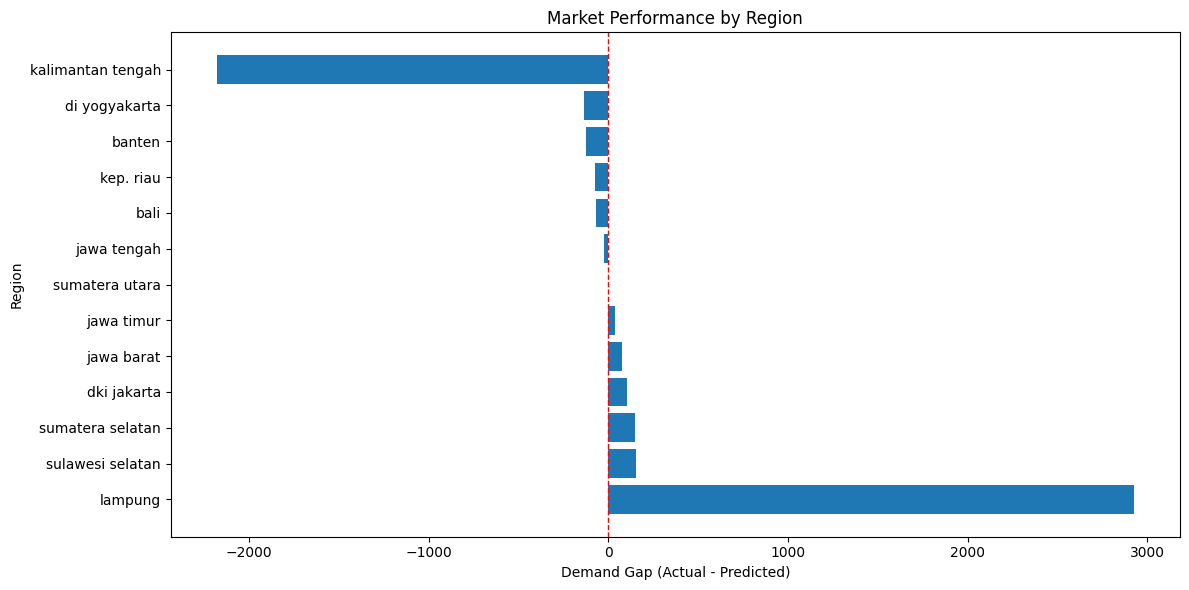

In [121]:
# Visualize demand gaps by region
plt.figure(figsize=(12, 6))
plt.barh(region_analysis["region"], region_analysis["demand_gap"])
plt.xlabel("Demand Gap (Actual - Predicted)")
plt.ylabel("Region")
plt.title("Market Performance by Region")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

# Positive gap = Overperforming (actual sales > predicted)
# Negative gap = Underperforming (actual sales < predicted)

TUNING OUR BEST PERFORMING MACHINE LEARNING MODEL: Random Forest Classifier
(with a max accuracy score of 0.7029126213592233)

In [ ]:
# Use randomized search CV to tune the Random Forest Classifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=RF,
    param_distributions=param_grid,
    n_iter=30,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(x_train, y_train)

print("Best Parameters:", rf_random.best_params_)
print("Best CV Accuracy:", rf_random.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best CV Accuracy: 0.6803510127523034


In [ ]:
rf_best = rf_random.best_estimator_
test_pred = rf_best.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, test_pred))

Test Accuracy: 0.6766990291262136


Although we already tuned this to the best settings, it is still not a good model accuracy, therefore we could see that we are still lacking with the features. Now it's time to add more features such as categorical features or even the 'customer review' (the comment from the customer in text form of that particular product). 

We proceed with vectorizing the text file to become numerical. Let's use OneHotEncoder for our categorical features, and using TF-IDF vectorizer for the customer review text (Interesting Note: Since tokopedia comments are in the Indonesian language we use the libarary Sastrawi in order to get the indonesian stop words to then be used by TF-IDF)! 

In [ ]:
# Use this libary for combing the numerical features with the categorical features
from sklearn.compose import ColumnTransformer

# This one is for the categorical features = [category, region]
from sklearn.preprocessing import OneHotEncoder

# This one is for the purely text feature (all suppose to be unique text data) = customer review
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# Get the indonesian stop words
stop_words_ind = StopWordRemoverFactory().get_stop_words()

from sklearn.pipeline import Pipeline

In [ ]:
numerical_features = ["price", "overall rating", "number sold", "total review", "salary"]
categorical_features = ["category", "region"] 
text_features = "customer review"

In [ ]:
X = data[numerical_features + categorical_features + [text_features]]

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            max_features=5000,
            stop_words=stop_words_ind,
            ngram_range=(1,2),
            sublinear_tf=True
        ), text_features),
        
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        
        ("num", "passthrough", numerical_features)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf_best)
])

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=432
)

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print("Final Model with Text + Categorical Features Accuracy:",
      accuracy_score(Y_test, y_pred))

print(classification_report(Y_test, y_pred))

Final Model with Text + Categorical Features Accuracy: 0.9174757281553398
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       521
           1       0.92      0.91      0.92       509

    accuracy                           0.92      1030
   macro avg       0.92      0.92      0.92      1030
weighted avg       0.92      0.92      0.92      1030



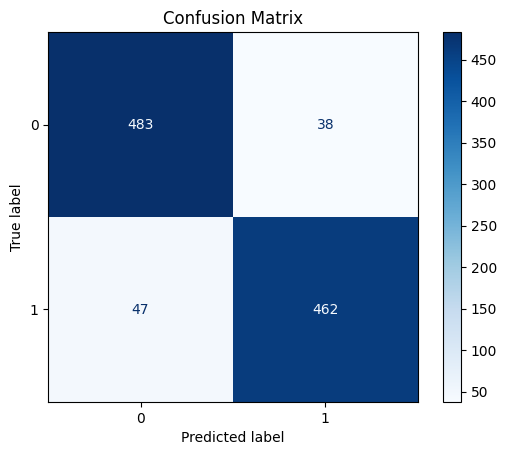

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    Y_test,
    display_labels=model.named_steps["classifier"].classes_,
    cmap="Blues",
    xticks_rotation="horizontal"
)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Prediction distribution:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

Prediction distribution:
0: 530
1: 500


In [ ]:
unique, counts = np.unique(Y_test, return_counts=True)
print("True label distribution:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

True label distribution:
0: 521
1: 509
